# COVID-19 Fake News Classifier

## 1) Imports y utilidades

In [4]:

import pandas as pd
import numpy as np
import re, json, os, joblib

from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
STOP = set(stopwords.words('english'))

# funciones auxiliares
def clean_text(s:str)->str:
    s = str(s).lower()
    s = re.sub(r"http\S+|www\S+"," ",s)
    s = re.sub(r"[^a-zA-Z\s]"," ",s)
    s = re.sub(r"\s+"," ",s).strip()
    s = " ".join([w for w in s.split() if w not in STOP])
    return s


def binarize_label(sentiment:str)->int:
    neg = {"negative", "extremely negative"}
    s = str(sentiment).strip().lower()
    return 0 if s in neg else 1  # Fake=0, Real=1

RANDOM_STATE = 42


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 2) Carga de datos y preparación de etiquetas

In [5]:

# Asegúrate de tener los archivos en el mismo directorio de trabajo del notebook
train_path = "Corona_NLP_train.csv"
test_path  = "Corona_NLP_test.csv"

train_df = pd.read_csv(train_path, encoding="latin-1")
test_df  = pd.read_csv(test_path,  encoding="latin-1")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("\nColumnas:", list(train_df.columns))

# Columnas esperadas: 'OriginalTweet' y 'Sentiment'
train_df['label'] = train_df['Sentiment'].apply(binarize_label)
test_df['label']  = test_df['Sentiment'].apply(binarize_label)

train_df['clean_text'] = train_df['OriginalTweet'].apply(clean_text)
test_df['clean_text']  = test_df['OriginalTweet'].apply(clean_text)

X_train, y_train = train_df['clean_text'], train_df['label']
X_test,  y_test  = test_df['clean_text'],  test_df['label']

print("\nEjemplo texto limpio:")
display(train_df[['OriginalTweet','clean_text','Sentiment','label']].head(3))


Train shape: (41157, 6)
Test shape: (3798, 6)

Columnas: ['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet', 'Sentiment']

Ejemplo texto limpio:


,OriginalTweet,clean_text,Sentiment,label
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,menyrbie phil gahan chrisitv,Neutral,1
1,advice Talk to your neighbours family to excha...,advice talk neighbours family exchange phone n...,Positive,1
2,Coronavirus Australia: Woolworths to give elde...,coronavirus australia woolworths give elderly ...,Positive,1


## 3) Pipeline 1 — TF-IDF + modelos clásicos

In [6]:

# TF-IDF
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,2))
Xtr_tfidf = tfidf.fit_transform(X_train)
Xte_tfidf = tfidf.transform(X_test)

# Modelos clásicos
models_tfidf = {
    "LogisticRegression": LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    "LinearSVC": LinearSVC(random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)
}

results_tfidf = {}
for name, mdl in models_tfidf.items():
    mdl.fit(Xtr_tfidf, y_train)
    pred = mdl.predict(Xte_tfidf)
    acc = accuracy_score(y_test, pred)
    f1  = f1_score(y_test, pred)
    print(f"\n--- {name} ---")
    print("Accuracy:", acc, " | F1:", f1)
    print(classification_report(y_test, pred, digits=4))
    results_tfidf[name] = {"acc": float(acc), "f1": float(f1), "model": mdl}

# Guardamos el mejor (por F1) de TF-IDF
best_tfidf_name = sorted(results_tfidf.keys(), key=lambda k: results_tfidf[k]["f1"], reverse=True)[0]
best_tfidf_model = results_tfidf[best_tfidf_name]["model"]
joblib.dump(tfidf, "tfidf_vectorizer.joblib")
joblib.dump(best_tfidf_model, f"tfidf_{best_tfidf_name}.joblib")
print(f"\n[TF-IDF] Mejor modelo: {best_tfidf_name}")



--- LogisticRegression ---
Accuracy: 0.8009478672985783  | F1: 0.8388059701492537
              precision    recall  f1-score   support

           0     0.8445    0.6583    0.7398      1633
           1     0.7790    0.9085    0.8388      2165

    accuracy                         0.8009      3798
   macro avg     0.8117    0.7834    0.7893      3798
weighted avg     0.8072    0.8009    0.7963      3798


--- LinearSVC ---
Accuracy: 0.8212216956292786  | F1: 0.8473814340301191
              precision    recall  f1-score   support

           0     0.8151    0.7557    0.7842      1633
           1     0.8253    0.8707    0.8474      2165

    accuracy                         0.8212      3798
   macro avg     0.8202    0.8132    0.8158      3798
weighted avg     0.8209    0.8212    0.8202      3798


--- RandomForest ---
Accuracy: 0.7669826224328594  | F1: 0.8113408654871029
              precision    recall  f1-score   support

           0     0.7940    0.6185    0.6954      1633
   

## 4) Pipeline 2 — Word2Vec + modelos clásicos (sin Naive Bayes)

In [7]:
from gensim.models import Word2Vec

# Tokenización simple (ya limpio)
train_tokens = [t.split() for t in X_train]
test_tokens  = [t.split() for t in X_test]

# Entrenar Word2Vec
w2v_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=2, workers=4)
dim = w2v_model.vector_size

def doc_vector(tokens, model, dim):
    vecs = [model.wv[w] for w in tokens if w in model.wv]
    if not vecs:
        return np.zeros(dim, dtype=np.float32)
    return np.mean(vecs, axis=0).astype(np.float32)

Xtr_w2v = np.vstack([doc_vector(t, w2v_model, dim) for t in train_tokens])
Xte_w2v = np.vstack([doc_vector(t, w2v_model, dim) for t in test_tokens])

models_w2v = {
    "LogisticRegression": LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    "LinearSVC": LinearSVC(random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)
}

results_w2v = {}
for name, mdl in models_w2v.items():
    mdl.fit(Xtr_w2v, y_train)
    pred = mdl.predict(Xte_w2v)
    acc = accuracy_score(y_test, pred)
    f1  = f1_score(y_test, pred)
    print(f"\n--- {name} ---")
    print("Accuracy:", acc, " | F1:", f1)
    print(classification_report(y_test, pred, digits=4))
    results_w2v[name] = {"acc": float(acc), "f1": float(f1), "model": mdl}

# Guardar bundle Word2Vec + mejor clasificador (por F1)
best_w2v_name = sorted(results_w2v.keys(), key=lambda k: results_w2v[k]["f1"], reverse=True)[0]
best_w2v_model = results_w2v[best_w2v_name]["model"]
joblib.dump({"w2v": w2v_model, "clf": best_w2v_model, "dim": dim}, "w2v_best_bundle.joblib")
print(f"\n[W2V] Mejor modelo: {best_w2v_name}")



--- LogisticRegression ---
Accuracy: 0.6771985255397578  | F1: 0.7573238321456849
              precision    recall  f1-score   support

           0     0.7234    0.4036    0.5181      1633
           1     0.6626    0.8836    0.7573      2165

    accuracy                         0.6772      3798
   macro avg     0.6930    0.6436    0.6377      3798
weighted avg     0.6887    0.6772    0.6545      3798


--- LinearSVC ---
Accuracy: 0.6877303844128488  | F1: 0.7649623464130004
              precision    recall  f1-score   support

           0     0.7437    0.4176    0.5349      1633
           1     0.6699    0.8915    0.7650      2165

    accuracy                         0.6877      3798
   macro avg     0.7068    0.6545    0.6499      3798
weighted avg     0.7016    0.6877    0.6660      3798


--- RandomForest ---
Accuracy: 0.665086887835703  | F1: 0.7469160366096299
              precision    recall  f1-score   support

           0     0.6926    0.3974    0.5051      1633
    

## 5) Deep Learning — BiLSTM y CNN-1D (Keras)

In [8]:

# Si no tienes TensorFlow instalado, instala y reinicia el kernel.
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

max_words = 50000
max_len   = 300

tok = Tokenizer(num_words=max_words, oov_token="<OOV>")
tok.fit_on_texts(list(X_train))

Xtr_seq = pad_sequences(tok.texts_to_sequences(X_train), maxlen=max_len, padding='post')
Xte_seq = pad_sequences(tok.texts_to_sequences(X_test),  maxlen=max_len, padding='post')
ytr = np.array(y_train)
yte = np.array(y_test)

joblib.dump({"tokenizer": tok, "max_len": max_len}, "models_tokenizer.joblib")

def build_bilstm():
    m = Sequential([
        Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
        Bidirectional(LSTM(64)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    m.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return m

def build_cnn():
    m = Sequential([
        Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
        Conv1D(128, kernel_size=5, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    m.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return m

# BiLSTM
bilstm = build_bilstm()
cb1 = [EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
       ModelCheckpoint("bilstm_best.keras", monitor='val_accuracy', save_best_only=True)]
history_bilstm = bilstm.fit(Xtr_seq, ytr, validation_split=0.15, epochs=10, batch_size=64, callbacks=cb1, verbose=2)
bilstm_acc = float(bilstm.evaluate(Xte_seq, yte, verbose=0)[1])
print("BiLSTM test acc:", bilstm_acc)

# CNN-1D
cnn = build_cnn()
cb2 = [EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
       ModelCheckpoint("cnn1d_best.keras", monitor='val_accuracy', save_best_only=True)]
history_cnn = cnn.fit(Xtr_seq, ytr, validation_split=0.15, epochs=10, batch_size=64, callbacks=cb2, verbose=2)
cnn_acc = float(cnn.evaluate(Xte_seq, yte, verbose=0)[1])
print("CNN-1D test acc:", cnn_acc)


c:\Users\franc\OneDrive\Desktop\practicas\AI\chatgpt\tf_env\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
547/547 - 204s - 372ms/step - accuracy: 0.7751 - loss: 0.4665 - val_accuracy: 0.8594 - val_loss: 0.3315
Epoch 2/10
547/547 - 199s - 364ms/step - accuracy: 0.9144 - loss: 0.2232 - val_accuracy: 0.8615 - val_loss: 0.3372
Epoch 3/10
547/547 - 320s - 586ms/step - accuracy: 0.9594 - loss: 0.1144 - val_accuracy: 0.8508 - val_loss: 0.4170
Epoch 4/10
547/547 - 318s - 581ms/step - accuracy: 0.9774 - loss: 0.0668 - val_accuracy: 0.8495 - val_loss: 0.5615
Epoch 5/10
547/547 - 206s - 376ms/step - accuracy: 0.9875 - loss: 0.0372 - val_accuracy: 0.8448 - val_loss: 0.7196
BiLSTM test acc: 0.8317535519599915
Epoch 1/10
547/547 - 85s - 156ms/step - accuracy: 0.7868 - loss: 0.4527 - val_accuracy: 0.8733 - val_loss: 0.3169
Epoch 2/10
547/547 - 82s - 150ms/step - accuracy: 0.9092 - loss: 0.2325 - val_accuracy: 0.8623 - val_loss: 0.3347
Epoch 3/10
547/547 - 80s - 146ms/step - accuracy: 0.9651 - loss: 0.1027 - val_accuracy: 0.8503 - val_loss: 0.4225
Epoch 4/10
547/547 - 79s - 145ms/step - accurac

### 5.1) Métricas F1 para modelos de DL

In [9]:

# Obtener F1 para comparación justa
pred_bilstm_proba = bilstm.predict(Xte_seq, verbose=0).ravel()
pred_cnn_proba    = cnn.predict(Xte_seq, verbose=0).ravel()

pred_bilstm = (pred_bilstm_proba >= 0.5).astype(int)
pred_cnn    = (pred_cnn_proba    >= 0.5).astype(int)

bilstm_f1 = f1_score(y_test, pred_bilstm)
cnn_f1    = f1_score(y_test, pred_cnn)

print({"bilstm_acc": bilstm_acc, "bilstm_f1": float(bilstm_f1),
       "cnn_acc": cnn_acc, "cnn_f1": float(cnn_f1)})


{'bilstm_acc': 0.8317535519599915, 'bilstm_f1': 0.8531372098368192, 'cnn_acc': 0.8262243270874023, 'cnn_f1': 0.8476454293628809}


## 6) Selección y guardado del **mejor modelo**

In [10]:

candidates = []

# TF-IDF best
from glob import glob
tfidf_model_paths = glob("tfidf_*.joblib")
if tfidf_model_paths:
    # Re-eval para extraer F1 en test
    best_path = tfidf_model_paths[0]
    best_name = os.path.splitext(os.path.basename(best_path))[0].replace("tfidf_","")
    tfidf_vec = joblib.load("tfidf_vectorizer.joblib")
    mdl = joblib.load(best_path)
    yhat = mdl.predict(Xte_tfidf)
    f1 = f1_score(y_test, yhat)
    candidates.append({"name": f"tfidf_{best_name}", "type":"tfidf", "path": best_path,
                       "vec":"tfidf_vectorizer.joblib", "f1": float(f1), "acc": float(accuracy_score(y_test, yhat))})

# W2V best
if os.path.exists("w2v_best_bundle.joblib"):
    w2v_bundle = joblib.load("w2v_best_bundle.joblib")
    clf = w2v_bundle["clf"]
    yhat = clf.predict(Xte_w2v)
    f1 = f1_score(y_test, yhat)
    candidates.append({"name":"w2v_best", "type":"w2v", "path":"w2v_best_bundle.joblib",
                       "f1": float(f1), "acc": float(accuracy_score(y_test, yhat))})

# DL
candidates.append({"name":"bilstm", "type":"dl", "path":"bilstm_best.keras",
                   "f1": float(bilstm_f1), "acc": float(bilstm_acc)})
candidates.append({"name":"cnn1d", "type":"dl", "path":"cnn1d_best.keras",
                   "f1": float(cnn_f1), "acc": float(cnn_acc)})

# Elegimos por F1 y en empate por acc
best = sorted(candidates, key=lambda x: (x.get("f1",0.0), x.get("acc",0.0)), reverse=True)[0]
with open("best_model.json","w") as f:
    json.dump(best, f, indent=2)
best


{'name': 'bilstm',
 'type': 'dl',
 'path': 'bilstm_best.keras',
 'f1': 0.8531372098368192,
 'acc': 0.8317535519599915}

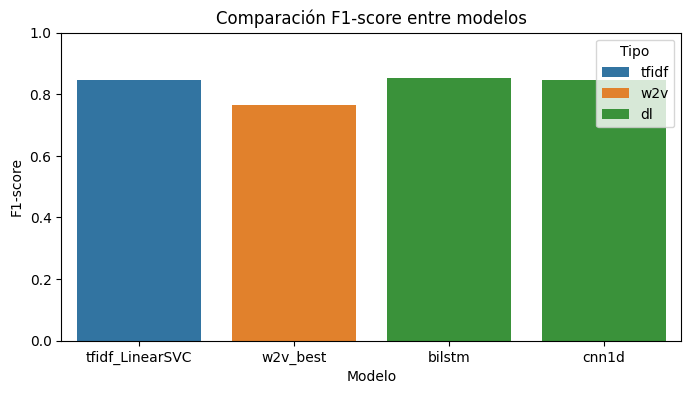

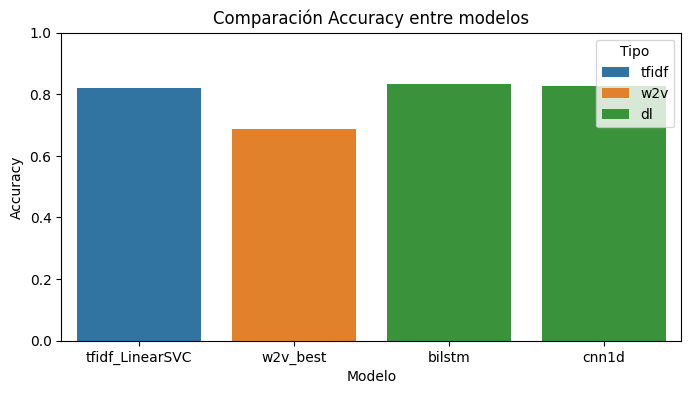

In [11]:
# ...después de la celda de selección y guardado del mejor modelo...

import matplotlib.pyplot as plt
import seaborn as sns

# Crear DataFrame con los resultados
import pandas as pd
df_models = pd.DataFrame(candidates)

plt.figure(figsize=(8,4))
sns.barplot(data=df_models, x="name", y="f1", hue="type")
plt.title("Comparación F1-score entre modelos")
plt.ylabel("F1-score")
plt.xlabel("Modelo")
plt.ylim(0,1)
plt.legend(title="Tipo")
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(data=df_models, x="name", y="acc", hue="type")
plt.title("Comparación Accuracy entre modelos")
plt.ylabel("Accuracy")
plt.xlabel("Modelo")
plt.ylim(0,1)
plt.legend(title="Tipo")
plt.show()

## 7) BONUS — Fine-tuning con DistilBERT (opcional)

In [12]:

try:
    from datasets import Dataset
    from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
    import numpy as np

    model_name = "distilbert-base-uncased"
    tok = AutoTokenizer.from_pretrained(model_name)

    def tokenize(batch):
        return tok(batch["text"], truncation=True, padding="max_length", max_length=256)

    dtrain = Dataset.from_dict({"text": list(X_train), "label": list(y_train.astype(int))}).map(tokenize, batched=True)
    dtest  = Dataset.from_dict({"text": list(X_test),  "label": list(y_test.astype(int))}).map(tokenize, batched=True)
    dtrain.set_format(type="torch", columns=["input_ids","attention_mask","label"])
    dtest.set_format(type="torch", columns=["input_ids","attention_mask","label"])

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        return {"accuracy": accuracy_score(labels, preds), "f1": f1_score(labels, preds)}

    args = TrainingArguments(
        output_dir="bert_ckpt",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=2,            # sube a 3–4 si tienes GPU/tiempo
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        learning_rate=5e-5,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        logging_steps=50
    )

    trainer = Trainer(model=model, args=args, train_dataset=dtrain, eval_dataset=dtest, compute_metrics=compute_metrics)
    trainer.train()
    bert_metrics = trainer.evaluate(dtest)
    print("DistilBERT metrics:", bert_metrics)

    trainer.save_model("models_bert_best")
    tok.save_pretrained("models_bert_best")

    # Añadir BERT a candidatos y, si gana, actualizar best_model.json
    candidates_bert = json.load(open("best_model.json"))
    # Reabrimos todo para comparar fácil
    all_cands = [candidates_bert] if isinstance(candidates_bert, dict) else []
    all_cands.append({"name":"distilbert", "type":"bert", "path":"models_bert_best",
                      "f1": float(bert_metrics.get("eval_f1", 0.0)), "acc": float(bert_metrics.get("eval_accuracy", 0.0))})
    # Aquí no sabemos los demás candidatos si no los rearmamos; así que comparamos solo con el actual best.
    best_now = sorted(all_cands, key=lambda x: (x.get("f1",0.0), x.get("acc",0.0)), reverse=True)[0]
    with open("best_model.json","w") as f:
        json.dump(best_now, f, indent=2)
    print("Best (pos-BERT):", best_now)

except Exception as e:
    print("DistilBERT no ejecutado (instala transformers/datasets/torch si lo necesitas). Error:", e)


c:\Users\franc\OneDrive\Desktop\practicas\AI\chatgpt\tf_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Map: 100%|██████████| 3798/3798 [00:00<00:00, 5028.06 examples/s]
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBERT no ejecutado (instala transformers/datasets/torch si lo necesitas). Error: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'


## 8) Exportar app web (Streamlit) desde el notebook

In [13]:

app_code = r'''
import streamlit as st
import json, joblib, numpy as np, re, os
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
STOP = set(stopwords.words("english"))

def clean_text(s:str)->str:
    s = s.lower()
    s = re.sub(r"http\S+|www\S+"," ",s)
    s = re.sub(r"[^a-zA-Z\s]"," ",s)
    s = re.sub(r"\s+"," ",s).strip()
    s = " ".join([w for w in s.split() if w not in STOP])
    return s

st.title("📰 COVID-19 Fake News Classifier")

if not os.path.exists("best_model.json"):
    st.error("No se encontró 'best_model.json'. Ejecuta el notebook para entrenar y seleccionar el mejor modelo.")
    st.stop()

with open("best_model.json") as f:
    BEST = json.load(f)

txt = st.text_area("Pega una noticia/artículo:")

if st.button("Clasificar"):
    if not txt.strip():
        st.warning("Escribe un texto.")
    else:
        kind = BEST.get("type")
        if kind == "tfidf":
            vec = joblib.load(BEST["vec"])
            model = joblib.load(BEST["path"])
            x = vec.transform([clean_text(txt)])
            y = int(model.predict(x)[0])
            proba = getattr(model, "predict_proba", None)
            p = float(max(proba(x)[0])) if proba else None

        elif kind == "w2v":
            bundle = joblib.load(BEST["path"])   # {"w2v":..., "clf":..., "dim":...}
            tokens = [w for w in word_tokenize(clean_text(txt)) if w.isalpha()]
            w2v, dim, clf = bundle["w2v"], bundle["dim"], bundle["clf"]
            vecs = [w2v.wv[w] for w in tokens if w in w2v.wv]
            doc = np.mean(vecs, axis=0) if vecs else np.zeros(dim)
            y = int(clf.predict([doc])[0]); p = None

        elif kind == "dl":
            from tensorflow.keras.models import load_model
            info = joblib.load("models_tokenizer.joblib")
            tok, max_len = info["tokenizer"], info["max_len"]
            from tensorflow.keras.preprocessing.sequence import pad_sequences
            seq = pad_sequences(tok.texts_to_sequences([txt]), maxlen=max_len, padding='post')
            model = load_model(BEST["path"])
            prob = float(model.predict(seq, verbose=0)[0][0])
            y = int(prob >= 0.5); p = prob if y==1 else 1-prob

        elif kind == "bert":
            from transformers import AutoTokenizer, AutoModelForSequenceClassification
            import torch
            name_or_path = BEST["path"]
            tok = AutoTokenizer.from_pretrained(name_or_path)
            mdl = AutoModelForSequenceClassification.from_pretrained(name_or_path)
            enc = tok([txt], truncation=True, padding=True, max_length=256, return_tensors="pt")
            with torch.no_grad():
                logits = mdl(**enc).logits
                prob = torch.softmax(logits, dim=-1).numpy()[0]
            y = int(np.argmax(prob))
            p = float(prob[y])

        else:
            st.error(f"Tipo de modelo no soportado: {kind}")
            st.stop()

        label = "REAL ✅" if y==1 else "FALSA ❌"
        st.success(f"Predicción: {label}" + (f" | Confianza: {p:.2f}" if p is not None else ""))
'''

with open("app_covid_news.py","w", encoding="utf-8") as f:
    f.write(app_code)

print("Archivo de app web escrito como: app_covid_news.py")
print("Ejecuta:  streamlit run app_covid_news.py")


Archivo de app web escrito como: app_covid_news.py
Ejecuta:  streamlit run app_covid_news.py
